# Maximum entropy thresholding
Entropy thresholding

# Implementation
## 1. Naive Implementation
This segmentation method relies on maximizing the interclass entropy. Both global and local (adaptive) methods have been implemented in this assignment. The formula for finding the optimal threshold $T_{opt}$ is as follows:
$$T_{opt}=\text{arg max}(H_f(T)+H_b(T))$$
Where:
$$ H_f(T)=-\sum_{i=1}^{T}\frac{P(i)}{P(T)} \times log\frac{P(i)}{P(T)} $$
$$ H_b(T)=-\sum_{i=T}^{G}\frac{P(i)}{1-P(T)} \times log\frac{P(i)}{1-P(T)} $$

Where $G$ is the number of intensity levels. As we’re dealing with 8bpp images, pixel values $p\in[0,255]$, this means that a simple exhaustive search with $T \in [1, 254]$ will be sufficient to find the optimal threshold.

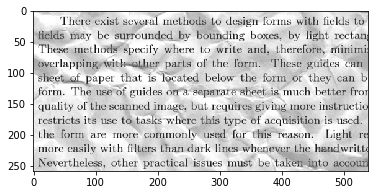

In [104]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('test_images/training_sample.png')

# Convert to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Helper function to show image on a Jupyter Notebook
def imshow(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

imshow(img)

In [105]:
# Helper function for calculating entropy
def entp(x):
    temp = np.multiply(x, np.log(x))
    temp[np.isnan(temp)] = 0
    return temp

To simplify the implementation, we create a separate variable $\theta(T)=H_f(T)+H_b(T)$. The optimal threshold then becomes $\text{arg max}(\theta(T))$.

In [106]:
# Maximum entropy
H = cv2.calcHist([img],[0],None,[256],[0,256])
H = H / np.sum(H)

In [107]:
theta = np.zeros(256)
Hf = np.zeros(256)
Hb = np.zeros(256)

for T in range(1,255):
    Hf[T] = - np.sum( entp(H[:T-1] / np.sum(H[1:T-1])) )
    Hb[T] = - np.sum( entp(H[T:] / np.sum(H[T:])) )
    theta[T] = Hf[T] + Hb[T]

theta_max = np.argmax(theta)
img_out = img > theta_max

Text(181,0,'$T_{opt}$')

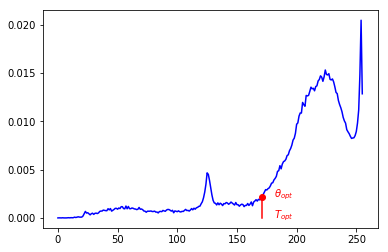

In [114]:
# Show histogram
plt.plot([i for i in range(256)], H, 'b')
plt.plot([theta_max], [H[theta_max]], 'ro')
plt.plot([theta_max, theta_max], [0, H[theta_max]], 'r')

plt.annotate("$\\theta_{opt}$", 
            xy=(theta_max, H[theta_max]), 
            xytext=(10+theta_max, H[theta_max]),
            color='r')

plt.annotate("$T_{opt}$", 
            xy=(theta_max, 0), 
            xytext=(10+theta_max, 0),
            color='r')

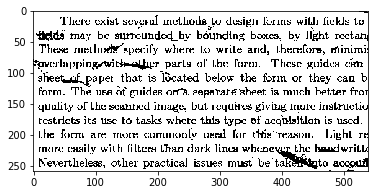

In [113]:
# Show image
imshow(img_out * 255)

## 2. Ideas for adaptive thresholding implementation

To improve segmentation, adaptive thresholding was used. For the adaptive thresholding implementation, two approaches have been addressed

1.	**Sliding window**: in this approach, each pixel has a different threshold value assigned to it given its neighboring pixels as shown below

    ![](assets/img1.jpg)
 
    For edge cases, we only consider the pixel-group around the examined pixel without adding any padding. This will cause the number of pixels used to determine the threshold for each pixel to be non-uniform. However, this way, it is guaranteed that the histogram around each pixel will not be disturbed by non-existent dark pixel values (in case of padding). This implementation has been more time consuming.

2.	**Block by block**: in this approach, the image was divided into blocks of 32 by 32 pixels. In each block, the local optimal threshold is used for segmenting the whole block of pixels.
    
    ![](assets/img2.jpg)

    This method has shown a significant improvement in performance. However, it caused some artifacts for a certain type of input pictures as will be shown in the Results part.

For the sake of comparison, both mean (using the image mean intensity value to be the threashold) and Otsu thresholding techniques have been implemented as well.
